In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split

from modules.experiment_pipeline import (
    ExperimentConfig,
    run_experiment_pipeline,
    results_to_dataframe,
    get_model,
    get_best_model,
    get_confusion_matrix,
    get_predictions,
)

/opt/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('../data/X_final.pkl', 'rb') as f:
    X = pickle.load(f)
with open('../data/labels.pkl', 'rb') as f:
    y = pickle.load(f)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Class distribution: {np.bincount(y)}")

X shape: (39100, 50029)
y shape: (39100,)
Class distribution: [17903 21197]


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print(f"Train size: {X_train.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

Train size: 29325
Test size: 9775


In [4]:
# Cell 4: Define Experiments (narrowed search)
experiments = [
    ExperimentConfig(
        name="LinearSVC",
        kernel="linear",
        param_space={
            "C": ("float_log", 5.0, 12.0),  
        },
        n_trials=10,
        cv_folds=5,
    ),

    ExperimentConfig(
        name="Poly_SVC",
        kernel="poly",
        param_space={
            "C": ("float_log", 0.2, 0.6),   
            "degree": ("int", 3, 4),         
            "coef0": ("float", 3.0, 5.5),   
        },
        n_trials=3,
        cv_folds=3,
    ),

    ExperimentConfig(
        name="RBF_SVC",
        kernel="rbf",
        param_space={
            "C": ("float_log", 0.8, 2.5),
            "gamma": ("float_log", 0.04, 0.12),
        },
        n_trials=2,
        cv_folds=3,
    )
]

In [5]:
# Cell 5: Run Pipeline
results = run_experiment_pipeline(
    X_train, y_train,
    X_test, y_test,
    experiments=experiments,
    experiment_name="fake_news_svm",
    random_state=42,
    n_jobs=-1,
    save_models=True,
    class_names=["Fake", "Real"],
)

2025-12-05 14:53:01 - experiment_pipeline - INFO - ############################################################
2025-12-05 14:53:01 - experiment_pipeline - INFO - EXPERIMENT PIPELINE: fake_news_svm
2025-12-05 14:53:01 - experiment_pipeline - INFO - Total experiments: 3
2025-12-05 14:53:01 - experiment_pipeline - INFO - ############################################################
2025-12-05 14:53:01 - experiment_pipeline - INFO - ============================================================
2025-12-05 14:53:01 - experiment_pipeline - INFO - EXPERIMENT: LinearSVC
2025-12-05 14:53:01 - experiment_pipeline - INFO - Kernel: linear | Trials: 10 | CV: 5-fold
2025-12-05 14:53:01 - experiment_pipeline - INFO - ============================================================
2025-12-05 14:53:01 - experiment_pipeline - INFO - Starting optimization: LinearSVC (10 trials, 5-fold CV)
Best trial: 0. Best value: 0.998534: 100%|██████████| 10/10 [00:51<00:00,  5.16s/it]
2025-12-05 14:53:53 - experiment_pipe

Metadata saved to /Users/otosamada/Documents/University Assignmnets/ML/DABN14_Project_1/notebooks/../model_metadata/experiments/fake_news_svm.json


In [9]:
# Cell 10: Optuna Optimization History (optional visualization)
import optuna
import optuna.visualization as vis

# Plot optimization history for each model
for name in ["LinearSVC", "RBF_SVC", "Poly_SVC"]:
    study = results[name]["study"]
    fig = optuna.visualization.plot_optimization_history(study)
    fig.update_layout(title=f"{name} Optimization History")
    fig.show()

In [6]:
# Cell 6: View Results as DataFrame
df_results = results_to_dataframe(results)
df_results

,model,kernel,test_accuracy,test_f1,cv_score,training_time_s,inference_time_ms,optimization_time_s,n_trials,C,degree,coef0,gamma
0,Poly_SVC,poly,1.000000,1.000000,1.000000,65.550348,1.819573,155.556251,3,0.222362,4.0,4.059067,NaN
1,RBF_SVC,rbf,0.999591,0.999623,0.999591,51.814690,1.306768,99.488353,2,2.327600,NaN,NaN,0.045334
2,LinearSVC,linear,0.998875,0.998962,0.998534,4.380028,0.000689,51.568678,10,6.962757,NaN,NaN,NaN


In [7]:
df_results.to_csv('../data/svm_experiment_results_run_2.csv', index=False)

In [10]:
# Cell 7: Access Individual Models
# Get best overall model
best_model, best_name = get_best_model(results, metric="test_f1")
print(f"Best model: {best_name}")

# Access specific models
linear_model = get_model(results, "LinearSVC")
rbf_model = get_model(results, "RBF_SVC")
poly_model = get_model(results, "Poly_SVC")

# View hyperparameters
print(f"\nLinearSVC params: {results['LinearSVC']['params']}")
print(f"RBF_SVC params: {results['RBF_SVC']['params']}")
print(f"Poly_SVC params: {results['Poly_SVC']['params']}")

Best model: Poly_SVC

LinearSVC params: {'C': 6.962756578220633}
RBF_SVC params: {'C': 2.3275996709642643, 'gamma': 0.045334060128042204}
Poly_SVC params: {'C': 0.22236155190732657, 'degree': 4, 'coef0': 4.0590671874701325}


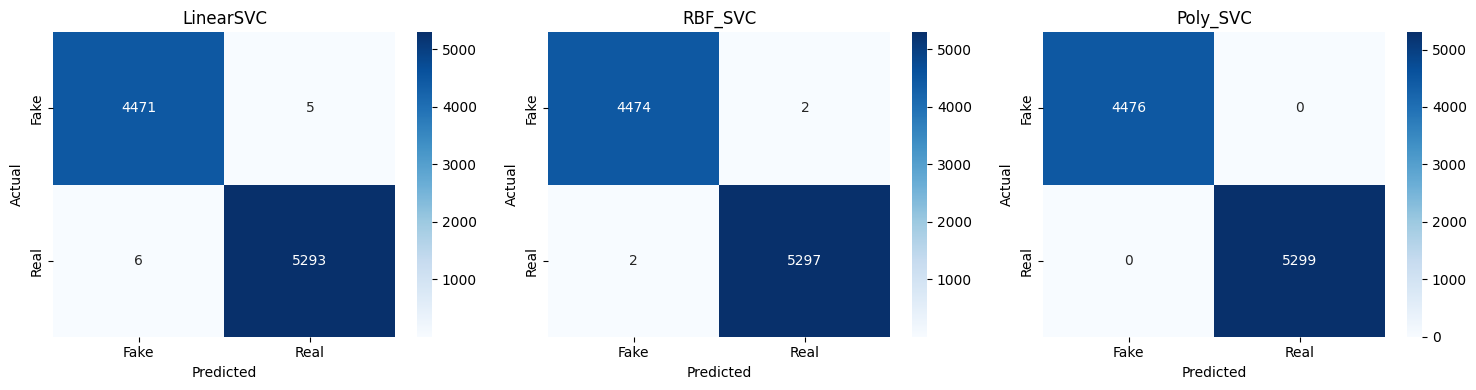

In [11]:
# Cell 8: Confusion Matrices
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, name in zip(axes, ["LinearSVC", "RBF_SVC", "Poly_SVC"]):
    cm = get_confusion_matrix(results, name)
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=['Fake', 'Real'],
        yticklabels=['Fake', 'Real'],
        ax=ax
    )
    ax.set_title(f"{name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

In [12]:
# Cell 9: Feature Importance (LinearSVC only)
# Load vectorizer to get feature names
with open('../data/artifacts/vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

feature_names = vectorizer.get_feature_names_out()
coefficients = linear_model.coef_[0][:len(feature_names)]

# Top features
n_top = 15
top_fake_idx = np.argsort(coefficients)[:n_top]
top_real_idx = np.argsort(coefficients)[-n_top:][::-1]

print("Top 15 FAKE indicators:")
for idx in top_fake_idx:
    print(f"  {feature_names[idx]:<25} {coefficients[idx]:.4f}")

print("\nTop 15 REAL indicators:")
for idx in top_real_idx:
    print(f"  {feature_names[idx]:<25} {coefficients[idx]:.4f}")

Top 15 FAKE indicators:
  t                         -1.6058
  this                      -1.2751
  ?                         -1.1946
  read more                 -1.1941
  just                      -1.1452
  st century                -1.0911
  <NUM> st century          -1.0911
  president trump           -1.0124
  <NUM> st                  -1.0059
  read                      -1.0045
  century                   -0.9791
  it s                      -0.9300
  america                   -0.9246
  st                        -0.9131
  obama                     -0.8994

Top 15 REAL indicators:
  said                      1.9473
  us                        1.9101
  ...                       1.3102
  on                        1.2200
  president donald          1.2118
  president donald trump    1.2116
  us president              1.1500
  said on                   1.1115
  on friday                 1.0864
  on monday                 1.0059
  monday                    0.9419
  friday                  

In [13]:
# Add this cell after loading the data and models

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the original dataframe once
true_df = pd.read_parquet('../data/data_cleaned_text.parquet')

# Get test indices for mapping back to original data
_, test_indices = train_test_split(
    np.arange(len(y)), 
    test_size=0.25, 
    random_state=42, 
    stratify=y
)

def get_model_by_name(model_name: str):
    """Get model and its name from results dict."""
    name_map = {
        "linear": "LinearSVC",
        "rbf": "RBF_SVC", 
        "poly": "Poly_SVC"
    }
    full_name = name_map.get(model_name.lower(), model_name)
    return get_model(results, full_name), full_name


def misclassification_details(model_name: str):
    """Show misclassification statistics for a model."""
    model, full_name = get_model_by_name(model_name)
    y_pred = model.predict(X_test)
    
    misclassified_mask = y_pred != y_test
    
    print(f"=== Misclassification Details: {full_name} ===\n")
    print(f"Total samples:       {len(y_test)}")
    print(f"Correct:             {sum(~misclassified_mask)}")
    print(f"Misclassified:       {sum(misclassified_mask)}")
    print(f"Accuracy:            {sum(~misclassified_mask) / len(y_test):.4f}")
    print(f"\n  - False Positives (Fake → Real): {sum((y_pred == 1) & (y_test == 0))}")
    print(f"  - False Negatives (Real → Fake): {sum((y_pred == 0) & (y_test == 1))}")
    
    return y_pred, misclassified_mask


def show_misclassified_samples(model_name: str, n_samples: int = 10):
    """Display misclassified samples with their text."""
    model, full_name = get_model_by_name(model_name)
    y_pred = model.predict(X_test)
    
    misclassified_mask = y_pred != y_test
    misclassified_indices = np.where(misclassified_mask)[0]
    
    # Limit to n_samples
    show_indices = misclassified_indices[:n_samples]
    original_indices = test_indices[show_indices]
    
    print(f"=== Misclassified Samples: {full_name} (showing {len(show_indices)}/{len(misclassified_indices)}) ===\n")
    
    for i, (test_idx, orig_idx) in enumerate(zip(show_indices, original_indices)):
        print(f"--- Sample {i+1} ---")
        print(f"True Label: {'Real' if y_test[test_idx] == 1 else 'Fake'}")
        print(f"Predicted:  {'Real' if y_pred[test_idx] == 1 else 'Fake'}")
        print(f"Title: {true_df.iloc[orig_idx]['title'][:200]}...")
        print(f"Text: {true_df.iloc[orig_idx]['text'][:500]}...")
        print()


def margin_analysis(model_name: str):
    """Analyze samples within the margin (close to decision boundary)."""
    model, full_name = get_model_by_name(model_name)
    
    # Get decision scores
    decision_scores = model.decision_function(X_test)
    
    print(f"=== Margin Analysis: {full_name} ===\n")
    print(f"Decision score range: [{decision_scores.min():.4f}, {decision_scores.max():.4f}]")
    print(f"Mean absolute score:  {np.abs(decision_scores).mean():.4f}")
    print()
    
    # Samples within margin (like your original output)
    margin_mask = np.abs(decision_scores) <= 1
    margin_indices = np.where(margin_mask)[0]
    
    print(f"Samples within margin (|score| <= 1): {len(margin_indices)}")
    print(f"Samples very close to boundary (|score| <= 0.5): {sum(np.abs(decision_scores) <= 0.5)}")
    print()
    
    # Additional thresholds
    thresholds = [0.1, 0.25, 2.0, 5.0]
    for thresh in thresholds:
        count = sum(np.abs(decision_scores) <= thresh)
        pct = count / len(decision_scores) * 100
        print(f"Samples within |score| <= {thresh}: {count} ({pct:.2f}%)")
    
    return decision_scores, margin_indices


def show_boundary_samples(model_name: str, n_samples: int = 10):
    """Display samples closest to the decision boundary."""
    model, full_name = get_model_by_name(model_name)
    y_pred = model.predict(X_test)
    decision_scores = model.decision_function(X_test)
    
    # Get indices sorted by closeness to boundary
    closest_indices = np.argsort(np.abs(decision_scores))[:n_samples]
    
    print(f"=== Top {n_samples} Samples Closest to Decision Boundary: {full_name} ===\n")
    
    for i, test_idx in enumerate(closest_indices):
        orig_idx = test_indices[test_idx]
        print(f"--- Sample {i+1} ---")
        print(f"Decision Score: {decision_scores[test_idx]:.4f}")
        print(f"True Label:     {'Real' if y_test[test_idx] == 1 else 'Fake'}")
        print(f"Predicted:      {'Real' if y_pred[test_idx] == 1 else 'Fake'}")
        print(f"Correct:        {'✓' if y_pred[test_idx] == y_test[test_idx] else '✗'}")
        print(f"Title: {true_df.iloc[orig_idx]['title'][:150]}")
        print(f"Text: {true_df.iloc[orig_idx]['text'][:300]}...")
        print()


def visualize_decision_scores(model_name: str, figsize: tuple = (12, 5)):
    """Visualize decision score distribution and margins."""
    model, full_name = get_model_by_name(model_name)
    decision_scores = model.decision_function(X_test)
    y_pred = model.predict(X_test)
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Plot 1: Decision score distribution by true class
    ax1 = axes[0]
    ax1.hist(decision_scores[y_test == 0], bins=50, alpha=0.6, label='Fake (True)', color='red')
    ax1.hist(decision_scores[y_test == 1], bins=50, alpha=0.6, label='Real (True)', color='blue')
    ax1.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Decision Boundary')
    ax1.axvline(x=-1, color='gray', linestyle=':', alpha=0.7, label='Margin')
    ax1.axvline(x=1, color='gray', linestyle=':', alpha=0.7)
    ax1.set_xlabel('Decision Score')
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'{full_name}: Decision Scores by True Class')
    ax1.legend()
    
    # Plot 2: Decision score distribution by prediction correctness
    ax2 = axes[1]
    correct_mask = y_pred == y_test
    ax2.hist(decision_scores[correct_mask], bins=50, alpha=0.6, label='Correct', color='green')
    ax2.hist(decision_scores[~correct_mask], bins=50, alpha=0.6, label='Misclassified', color='orange')
    ax2.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Decision Boundary')
    ax2.axvline(x=-1, color='gray', linestyle=':', alpha=0.7)
    ax2.axvline(x=1, color='gray', linestyle=':', alpha=0.7)
    ax2.set_xlabel('Decision Score')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'{full_name}: Correct vs Misclassified')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary stats
    print(f"\n=== Decision Score Summary: {full_name} ===")
    print(f"Fake samples - Mean score: {decision_scores[y_test == 0].mean():.4f}")
    print(f"Real samples - Mean score: {decision_scores[y_test == 1].mean():.4f}")
    print(f"Misclassified - Mean |score|: {np.abs(decision_scores[~correct_mask]).mean():.4f}")
    print(f"Correct - Mean |score|: {np.abs(decision_scores[correct_mask]).mean():.4f}")


def full_model_analysis(model_name: str, n_misclassified: int = 5, n_boundary: int = 5):
    """Run all analyses for a single model."""
    print("=" * 60)
    print(f"FULL ANALYSIS: {model_name.upper()}")
    print("=" * 60)
    print()
    
    # 1. Misclassification details
    misclassification_details(model_name)
    print()
    
    # 2. Margin analysis
    margin_analysis(model_name)
    print()
    
    # 3. Visualize decision scores
    visualize_decision_scores(model_name)
    print()
    
    # 4. Show misclassified samples
    show_misclassified_samples(model_name, n_samples=n_misclassified)
    
    # 5. Show boundary samples
    show_boundary_samples(model_name, n_samples=n_boundary)

FULL ANALYSIS: LINEAR

=== Misclassification Details: LinearSVC ===

Total samples:       9775
Correct:             9764
Misclassified:       11
Accuracy:            0.9989

  - False Positives (Fake → Real): 5
  - False Negatives (Real → Fake): 6

=== Margin Analysis: LinearSVC ===

Decision score range: [-11.8708, 3.4856]
Mean absolute score:  2.3362

Samples within margin (|score| <= 1): 437
Samples very close to boundary (|score| <= 0.5): 75

Samples within |score| <= 0.1: 7 (0.07%)
Samples within |score| <= 0.25: 23 (0.24%)
Samples within |score| <= 2.0: 4962 (50.76%)
Samples within |score| <= 5.0: 9363 (95.79%)



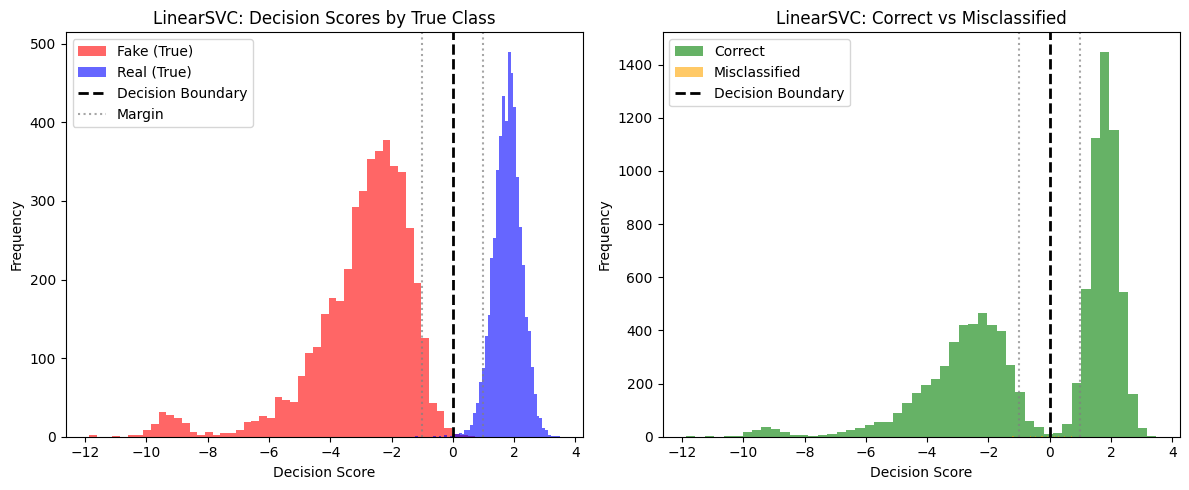


=== Decision Score Summary: LinearSVC ===
Fake samples - Mean score: -2.9928
Real samples - Mean score: 1.7799
Misclassified - Mean |score|: 0.4121
Correct - Mean |score|: 2.3384

=== Misclassified Samples: LinearSVC (showing 5/11) ===

--- Sample 1 ---
True Label: Fake
Predicted:  Real
Title: Seven Iranians freed in the prisoner swap have not returned to Iran...
Text: 21st Century Wire says This week, the historic international Iranian Nuclear Deal was punctuated by a two-way prisoner swap between Washington and Tehran, but it didn t end quite the way everyone expected. On the Iranian side, one of the U.S. citizens who was detained in Iran, Nosratollah Khosravi-Roodsari, has stayed in Iran, but on the U.S. side   all 7 of the Iranians held in U.S. prisons DID NOT show up to their flight to Geneva for the prisoner exchange   with at least 3 electing to stay in...

--- Sample 2 ---
True Label: Real
Predicted:  Fake
Title: Nigerian oil union PENGASSAN suspends strike: union president...

In [14]:
full_model_analysis("linear", n_misclassified=5, n_boundary=5)

FULL ANALYSIS: POLY

=== Misclassification Details: Poly_SVC ===

Total samples:       9775
Correct:             9775
Misclassified:       0
Accuracy:            1.0000

  - False Positives (Fake → Real): 0
  - False Negatives (Real → Fake): 0

=== Margin Analysis: Poly_SVC ===

Decision score range: [-891.1424, 1.3028]
Mean absolute score:  1.2306

Samples within margin (|score| <= 1): 344
Samples very close to boundary (|score| <= 0.5): 0

Samples within |score| <= 0.1: 0 (0.00%)
Samples within |score| <= 0.25: 0 (0.00%)
Samples within |score| <= 2.0: 9763 (99.88%)
Samples within |score| <= 5.0: 9774 (99.99%)



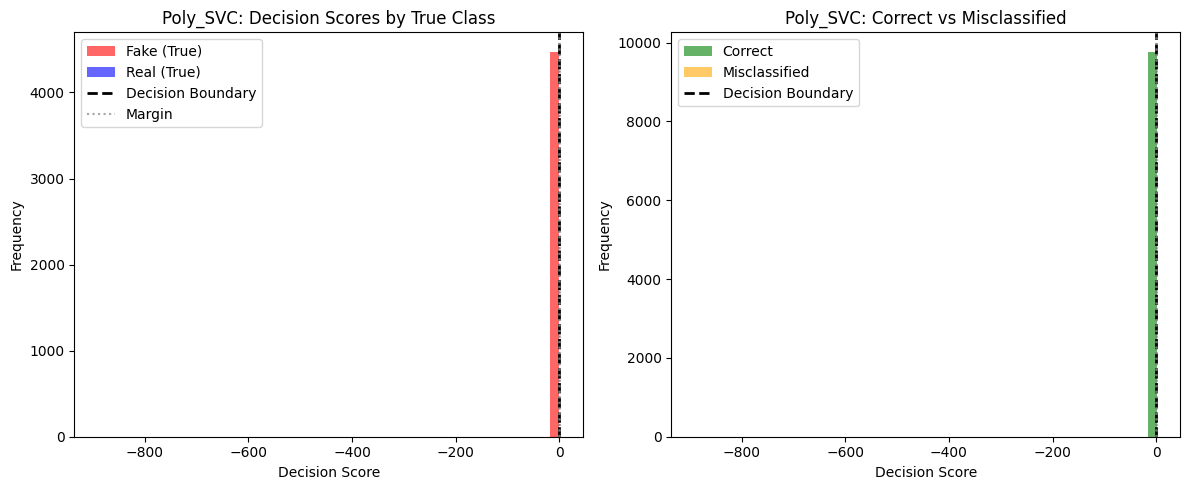


=== Decision Score Summary: Poly_SVC ===
Fake samples - Mean score: -1.4011
Real samples - Mean score: 1.0865
Misclassified - Mean |score|: nan
Correct - Mean |score|: 1.2306



/var/folders/8f/6znkn6r55qj5dgt5vxxlvwjm0000gn/T/ipykernel_70479/858888674.py:163: RuntimeWarning:

Mean of empty slice.

/opt/miniconda3/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning:

invalid value encountered in scalar divide



=== Misclassified Samples: Poly_SVC (showing 0/0) ===

=== Top 5 Samples Closest to Decision Boundary: Poly_SVC ===

--- Sample 1 ---
Decision Score: -0.7799
True Label:     Fake
Predicted:      Fake
Correct:        ✓
Title: PRICELESS! MILO DESTROYS Heckling Muslim Woman…Crowd Chants USA! USA! USA! [Video] #MiloYiannopoulos
Text:  ...

--- Sample 2 ---
Decision Score: 0.8426
True Label:     Real
Predicted:      Real
Correct:        ✓
Title: Anti-Zuma MP quits South Africa's 'corrupt' ANC
Text: African National Congress (ANC) MP Makhosi Khoza, a strident critic of scandal-plagued President Jacob Zuma, quit South Africa s ruling party on Thursday, labeling Nelson Mandela s 105-year-old liberation movement  alien and corrupt . The 47-year-old Zulu linguistics expert, an ANC supporter since t...

--- Sample 3 ---
Decision Score: -0.8429
True Label:     Fake
Predicted:      Fake
Correct:        ✓
Title: (Video) Angry Latino Activist: “Ultimately, it doesn’t matter if we’re undocumented.”
Te

In [15]:
full_model_analysis("poly", n_misclassified=5, n_boundary=5)

FULL ANALYSIS: RBF

=== Misclassification Details: RBF_SVC ===

Total samples:       9775
Correct:             9771
Misclassified:       4
Accuracy:            0.9996

  - False Positives (Fake → Real): 2
  - False Negatives (Real → Fake): 2

=== Margin Analysis: RBF_SVC ===

Decision score range: [-2.6510, 1.8447]
Mean absolute score:  1.4693

Samples within margin (|score| <= 1): 355
Samples very close to boundary (|score| <= 0.5): 30

Samples within |score| <= 0.1: 4 (0.04%)
Samples within |score| <= 0.25: 16 (0.16%)
Samples within |score| <= 2.0: 9180 (93.91%)
Samples within |score| <= 5.0: 9775 (100.00%)



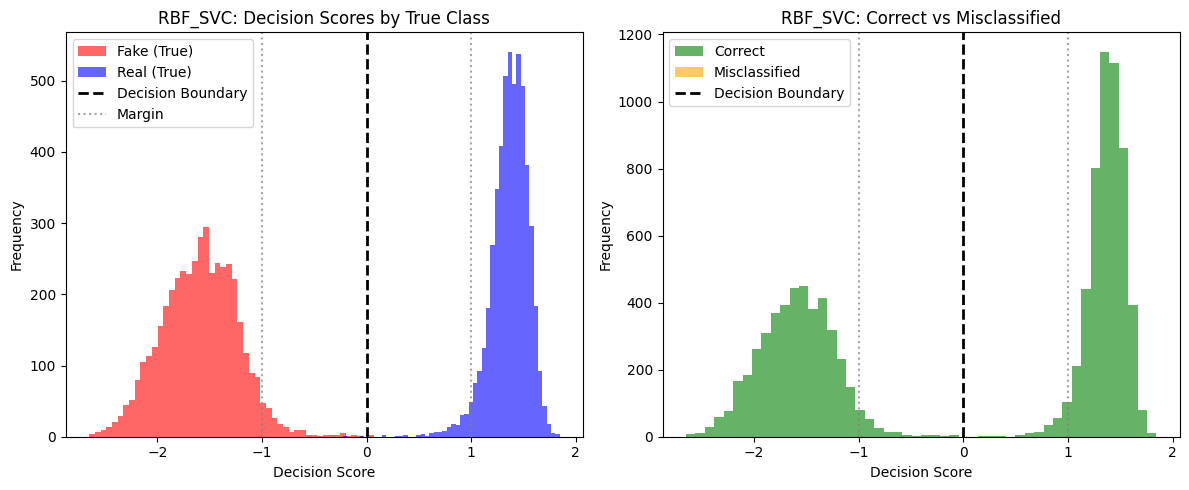


=== Decision Score Summary: RBF_SVC ===
Fake samples - Mean score: -1.5934
Real samples - Mean score: 1.3644
Misclassified - Mean |score|: 0.0925
Correct - Mean |score|: 1.4699

=== Misclassified Samples: RBF_SVC (showing 4/4) ===

--- Sample 1 ---
True Label: Real
Predicted:  Fake
Title: House delays vote on healthcare bill: MSNBC...
Text: The House of Representatives on Thursday delayed a vote on legislation to begin dismantling Obamacare as President Donald Trump and leaders in Congress labored to find enough support among fellow Republicans for their version of a new federal healthcare policy, MSNBC reported, citing multiple House leadership sources The reported delay marked a setback for Trump, who is seeking his first major legislative victory and who campaigned on a promise to repeal and replace President Barack Obama’s land...

--- Sample 2 ---
True Label: Fake
Predicted:  Real
Title:  Fed Up Republicans Threaten Third Party Option If Trump Is The Nominee...
Text: I ve been sa

In [16]:
full_model_analysis("rbf", n_misclassified=5, n_boundary=5)

In [17]:
# Add this cell with the other helper functions

import shap

def shap_analysis(model_name: str, n_samples: int = 100, n_boundary_samples: int = 5):
    """
    Perform SHAP analysis on samples close to decision boundary.
    
    Args:
        model_name: "linear", "rbf", or "poly"
        n_samples: Number of background samples for SHAP explainer
        n_boundary_samples: Number of boundary samples to analyze
    """
    model, full_name = get_model_by_name(model_name)
    
    print(f"=== SHAP Analysis: {full_name} ===\n")
    
    # Get decision scores to find boundary samples
    decision_scores = model.decision_function(X_test)
    
    # Get indices of samples closest to boundary
    boundary_indices = np.argsort(np.abs(decision_scores))[:n_boundary_samples]
    
    # Sample background data for SHAP (use subset for speed)
    np.random.seed(42)
    background_indices = np.random.choice(X_train.shape[0], size=n_samples, replace=False)
    X_background = X_train[background_indices]
    
    # Get boundary samples
    X_boundary = X_test[boundary_indices]
    
    print(f"Using {n_samples} background samples")
    print(f"Analyzing {n_boundary_samples} samples closest to decision boundary\n")
    
    # Create SHAP explainer
    # For Linear SVM, we can use the coefficients directly
    if model_name.lower() == "linear":
        # Linear model - use coefficients for faster explanation
        explainer = shap.LinearExplainer(model, X_background, feature_perturbation="interventional")
    else:
        # For non-linear kernels, use KernelExplainer (slower)
        print("Note: Using KernelExplainer for non-linear kernel (this may take a while)...")
        explainer = shap.KernelExplainer(model.decision_function, X_background)
    
    # Calculate SHAP values
    print("Calculating SHAP values...")
    shap_values = explainer.shap_values(X_boundary)
    
    # Get feature names
    with open('../data/artifacts/vectorizer.pkl', 'rb') as f:
        vectorizer = pickle.load(f)
    feature_names = list(vectorizer.get_feature_names_out())
    
    # Add numerical feature names
    num_features = [
        'repost_count', 'text_exclamation_count', 'text_capital_ratio', 
        'text_avg_sentence_length', 'title_exclamation_count', 'title_capital_ratio',
        'text_sentiment_polarity', 'text_sentiment_subjectivity',
        'title_sentiment_polarity', 'title_sentiment_subjectivity',
        'text_emotion_score', 'title_emotion_score',
        'month_sin', 'month_cos', 'day_sin', 'day_cos'
    ]
    feature_names.extend(num_features)
    
    # Add categorical feature names (one-hot encoded)
    cat_features = ['subject_WorldNews', 'text_emotion_anger', 'text_emotion_disgust', 
                    'text_emotion_fear', 'text_emotion_joy', 'text_emotion_neutral',
                    'text_emotion_sadness', 'text_emotion_surprise',
                    'title_emotion_anger', 'title_emotion_disgust', 
                    'title_emotion_fear', 'title_emotion_joy', 'title_emotion_neutral',
                    'title_emotion_sadness', 'title_emotion_surprise']
    feature_names.extend(cat_features)
    
    # Truncate or pad feature names to match X shape
    n_features = X_boundary.shape[1]
    if len(feature_names) < n_features:
        feature_names.extend([f'feature_{i}' for i in range(len(feature_names), n_features)])
    feature_names = feature_names[:n_features]
    
    # Plot summary for all boundary samples
    print("\n--- SHAP Summary Plot (Top Features Across Boundary Samples) ---")
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_boundary.toarray() if hasattr(X_boundary, 'toarray') else X_boundary, 
                      feature_names=feature_names, max_display=15, show=False)
    plt.tight_layout()
    plt.show()
    
    # Individual sample analysis
    y_pred = model.predict(X_test)
    
    for i, test_idx in enumerate(boundary_indices):
        orig_idx = test_indices[test_idx]
        
        print(f"\n{'='*60}")
        print(f"Sample {i+1}: Decision Score = {decision_scores[test_idx]:.4f}")
        print(f"True: {'Real' if y_test[test_idx] == 1 else 'Fake'} | "
              f"Predicted: {'Real' if y_pred[test_idx] == 1 else 'Fake'} | "
              f"{'✓ Correct' if y_pred[test_idx] == y_test[test_idx] else '✗ Wrong'}")
        print(f"Title: {true_df.iloc[orig_idx]['title'][:100]}...")
        print('='*60)
        
        # Get top 10 features for this sample
        sample_shap = shap_values[i] if len(shap_values.shape) == 2 else shap_values[i]
        
        # Get indices of top 10 absolute SHAP values
        top_indices = np.argsort(np.abs(sample_shap))[-10:][::-1]
        
        print("\nTop 10 Features Influencing This Prediction:")
        print("-" * 50)
        print(f"{'Feature':<35} {'SHAP Value':>12} {'Direction':<10}")
        print("-" * 50)
        
        for idx in top_indices:
            shap_val = sample_shap[idx]
            direction = "→ Real" if shap_val > 0 else "→ Fake"
            print(f"{feature_names[idx]:<35} {shap_val:>12.4f} {direction:<10}")
        
        # Waterfall plot for this sample
        plt.figure(figsize=(10, 6))
        shap.waterfall_plot(
            shap.Explanation(
                values=sample_shap, 
                base_values=explainer.expected_value if hasattr(explainer, 'expected_value') else 0,
                data=X_boundary[i].toarray().flatten() if hasattr(X_boundary, 'toarray') else X_boundary[i],
                feature_names=feature_names
            ),
            max_display=10,
            show=False
        )
        plt.title(f"Sample {i+1}: {'Real' if y_test[test_idx] == 1 else 'Fake'} "
                  f"(Predicted: {'Real' if y_pred[test_idx] == 1 else 'Fake'})")
        plt.tight_layout()
        plt.show()
    
    return shap_values, boundary_indices, feature_names


def shap_force_plot(model_name: str, sample_index: int = None):
    """
    Create a force plot for a specific sample or the sample closest to boundary.
    
    Args:
        model_name: "linear", "rbf", or "poly"
        sample_index: Index in X_test (if None, uses closest to boundary)
    """
    model, full_name = get_model_by_name(model_name)
    
    decision_scores = model.decision_function(X_test)
    
    if sample_index is None:
        sample_index = np.argmin(np.abs(decision_scores))
        print(f"Using sample closest to boundary (index {sample_index})")
    
    # Background samples
    np.random.seed(42)
    background_indices = np.random.choice(X_train.shape[0], size=100, replace=False)
    X_background = X_train[background_indices]
    
    # Create explainer
    if model_name.lower() == "linear":
        explainer = shap.LinearExplainer(model, X_background, feature_perturbation="interventional")
    else:
        explainer = shap.KernelExplainer(model.decision_function, X_background)
    
    # Get SHAP values for this sample
    X_sample = X_test[sample_index:sample_index+1]
    shap_values = explainer.shap_values(X_sample)
    
    # Get feature names
    with open('../data/artifacts/vectorizer.pkl', 'rb') as f:
        vectorizer = pickle.load(f)
    feature_names = list(vectorizer.get_feature_names_out())
    
    n_features = X_sample.shape[1]
    if len(feature_names) < n_features:
        feature_names.extend([f'feature_{i}' for i in range(len(feature_names), n_features)])
    feature_names = feature_names[:n_features]
    
    # Print sample info
    orig_idx = test_indices[sample_index]
    y_pred = model.predict(X_test)
    
    print(f"\n=== Force Plot: {full_name} ===")
    print(f"Decision Score: {decision_scores[sample_index]:.4f}")
    print(f"True: {'Real' if y_test[sample_index] == 1 else 'Fake'}")
    print(f"Predicted: {'Real' if y_pred[sample_index] == 1 else 'Fake'}")
    print(f"Title: {true_df.iloc[orig_idx]['title'][:100]}...")
    
    # Create force plot
    shap.initjs()
    return shap.force_plot(
        explainer.expected_value if hasattr(explainer, 'expected_value') else 0,
        shap_values[0],
        X_sample.toarray()[0] if hasattr(X_sample, 'toarray') else X_sample[0],
        feature_names=feature_names
    )

=== SHAP Analysis: LinearSVC ===

Using 100 background samples
Analyzing 5 samples closest to decision boundary

Calculating SHAP values...

--- SHAP Summary Plot (Top Features Across Boundary Samples) ---


/opt/miniconda3/lib/python3.13/site-packages/shap/explainers/_linear.py:99: FutureWarning:

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).

/var/folders/8f/6znkn6r55qj5dgt5vxxlvwjm0000gn/T/ipykernel_70479/3605954171.py:83: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



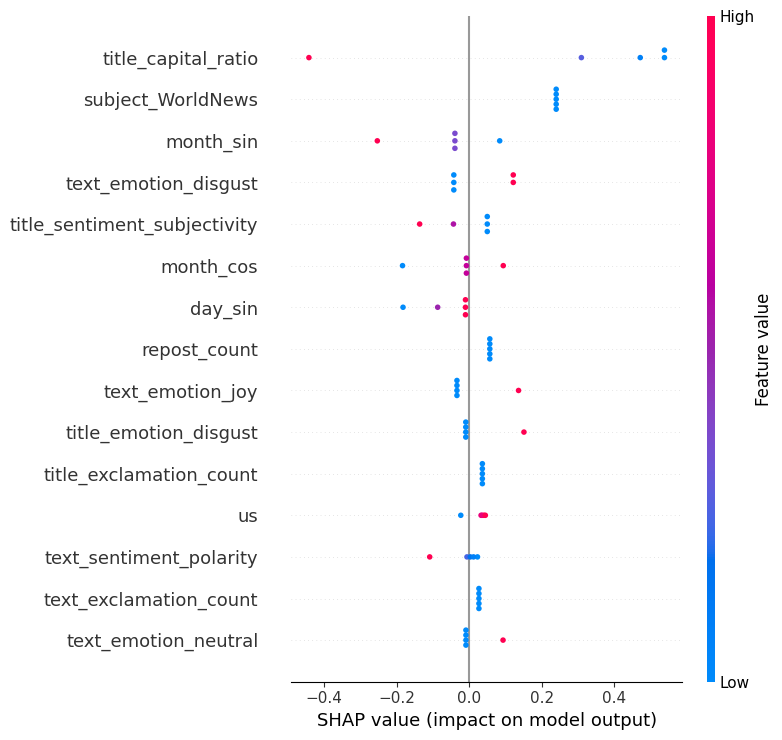


Sample 1: Decision Score = -0.0040
True: Fake | Predicted: Fake | ✓ Correct
Title: Jimmy Kimmel’s Hysterical Take On The Republican Debate [Video]...

Top 10 Features Influencing This Prediction:
--------------------------------------------------
Feature                               SHAP Value Direction 
--------------------------------------------------
title_capital_ratio                       0.4716 → Real    
subject_WorldNews                         0.2398 → Real    
title_emotion_disgust                     0.1508 → Real    
title_sentiment_subjectivity             -0.1368 → Fake    
text_emotion_joy                          0.1359 → Real    
text_sentiment_polarity                  -0.1091 → Fake    
republican                                0.0726 → Real    
repost_count                              0.0567 → Real    
jimmy                                    -0.0492 → Fake    
text_emotion_disgust                     -0.0426 → Fake    


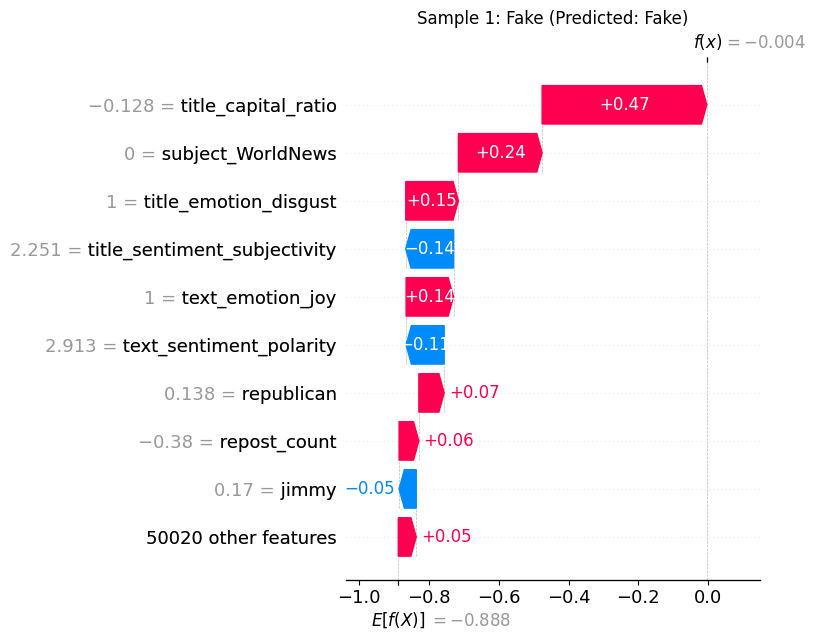


Sample 2: Decision Score = 0.0221
True: Real | Predicted: Real | ✓ Correct
Title: Trump attacks FBI on leakers of Russia reports: 'FIND NOW'...

Top 10 Features Influencing This Prediction:
--------------------------------------------------
Feature                               SHAP Value Direction 
--------------------------------------------------
title_capital_ratio                      -0.4423 → Fake    
month_sin                                -0.2536 → Fake    
subject_WorldNews                         0.2398 → Real    
text_emotion_disgust                      0.1214 → Real    
month_cos                                 0.0938 → Real    
day_sin                                  -0.0871 → Fake    
repost_count                              0.0567 → Real    
day_cos                                   0.0539 → Real    
on friday                                 0.0498 → Real    
title_sentiment_subjectivity              0.0497 → Real    


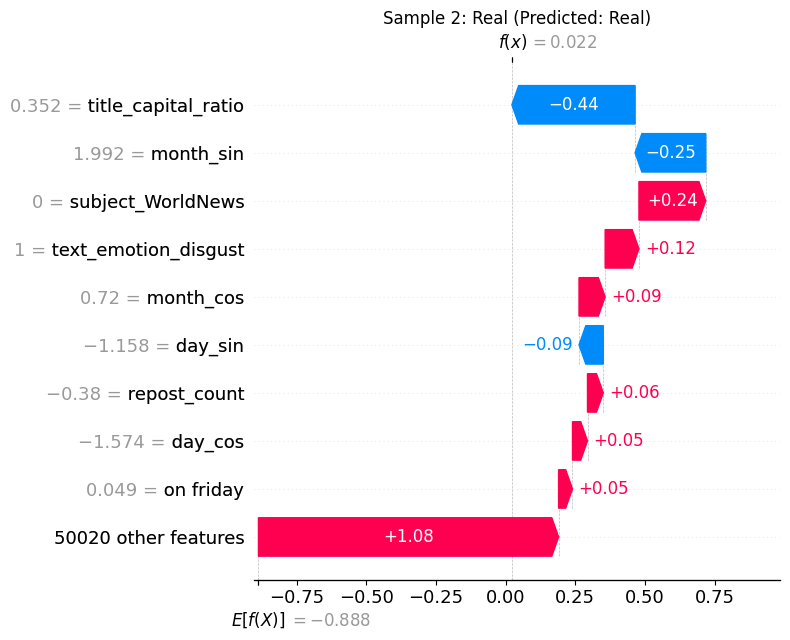


Sample 3: Decision Score = 0.0490
True: Fake | Predicted: Real | ✗ Wrong
Title: Why John McCain Will Never Vote to Repeal and Replace Obamacare...

Top 10 Features Influencing This Prediction:
--------------------------------------------------
Feature                               SHAP Value Direction 
--------------------------------------------------
title_capital_ratio                       0.3092 → Real    
subject_WorldNews                         0.2398 → Real    
text_emotion_disgust                      0.1214 → Real    
repost_count                              0.0567 → Real    
title_sentiment_subjectivity              0.0497 → Real    
us                                        0.0443 → Real    
read more                                -0.0434 → Fake    
month_sin                                -0.0396 → Fake    
text_avg_sentence_length                  0.0366 → Real    
title_exclamation_count                   0.0361 → Real    


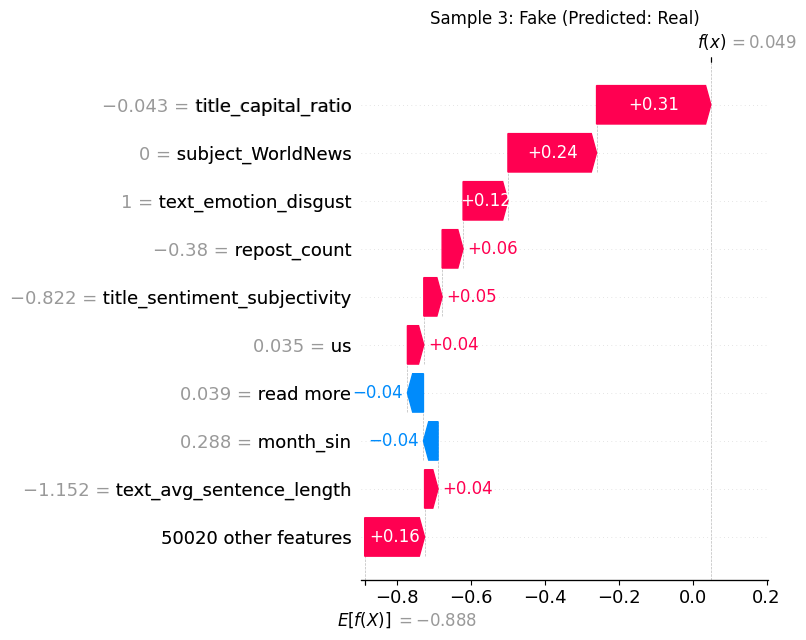


Sample 4: Decision Score = -0.0516
True: Real | Predicted: Fake | ✗ Wrong
Title: U.S. Women's Open must leave Trump National, says Burk...

Top 10 Features Influencing This Prediction:
--------------------------------------------------
Feature                               SHAP Value Direction 
--------------------------------------------------
title_capital_ratio                       0.5384 → Real    
subject_WorldNews                         0.2398 → Real    
month_cos                                -0.1841 → Fake    
day_sin                                  -0.1827 → Fake    
month_sin                                 0.0840 → Real    
repost_count                              0.0567 → Real    
title_sentiment_subjectivity             -0.0436 → Fake    
text_emotion_disgust                     -0.0426 → Fake    
us                                        0.0403 → Real    
title_exclamation_count                   0.0361 → Real    


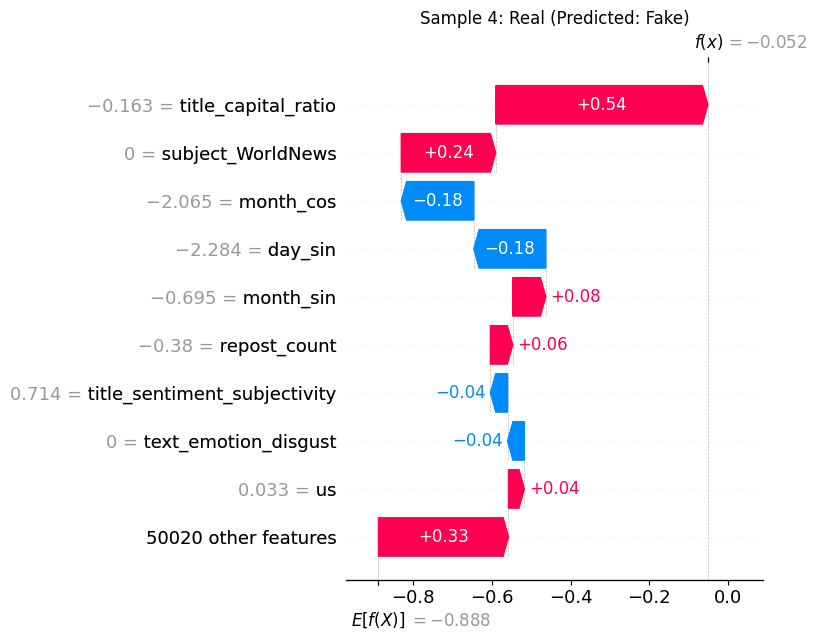


Sample 5: Decision Score = -0.0560
True: Fake | Predicted: Fake | ✓ Correct
Title: Cities Across America Are Replacing Columbus Day With Indigenous People’s Day...

Top 10 Features Influencing This Prediction:
--------------------------------------------------
Feature                               SHAP Value Direction 
--------------------------------------------------
title_capital_ratio                       0.5384 → Real    
subject_WorldNews                         0.2398 → Real    
text_emotion_neutral                      0.0932 → Real    
repost_count                              0.0567 → Real    
title_sentiment_subjectivity              0.0497 → Real    
text_emotion_disgust                     -0.0426 → Fake    
monday                                    0.0419 → Real    
month_sin                                -0.0396 → Fake    
t                                        -0.0370 → Fake    
title_exclamation_count                   0.0361 → Real    


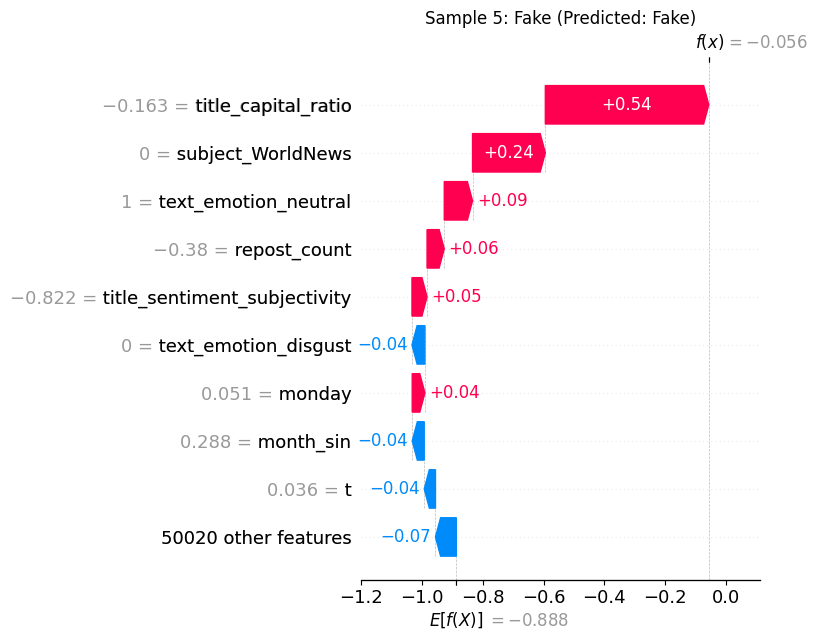

In [18]:
shap_values, indices, features = shap_analysis("linear", n_samples=100, n_boundary_samples=5)

In [19]:
shap_force_plot("linear", sample_index=42)



=== Force Plot: LinearSVC ===
Decision Score: 1.8454
True: Real
Predicted: Real
Title: Israel must enact law if it wants to hold militants' remains as bargaining chips: court...


/opt/miniconda3/lib/python3.13/site-packages/shap/explainers/_linear.py:99: FutureWarning:

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).



In [7]:
from sklearn.svm import SVC
from sklearn.metrics.pairwise import linear_kernel, rbf_kernel, polynomial_kernel
import numpy as np

# ============================================
# OPTION 1: Custom Kernel Function
# ============================================
# Must accept two matrices X and Y and return the kernel matrix K

def custom_linear_with_bias(X, Y):
    """Linear kernel with added bias term: K(x,y) = x·y + c"""
    c = 1.0  # Bias term
    return linear_kernel(X, Y) + c

def weighted_linear_kernel(X, Y):
    """
    Linear kernel that could weight features differently
    Useful if you want to weight TF-IDF features vs numerical features
    """
    # For sparse matrices, convert to dense for custom operations
    # WARNING: This can be memory-intensive for large matrices!
    return X @ Y.T  # Standard dot product

def sigmoid_kernel(X, Y):
    """Sigmoid/Tanh kernel: K(x,y) = tanh(gamma * x·y + coef0)"""
    gamma = 0.001
    coef0 = 0
    linear = X @ Y.T
    if hasattr(linear, 'toarray'):
        linear = linear.toarray()
    return np.tanh(gamma * linear + coef0)

# Train with custom kernel
print("=" * 50)
print("Training Custom Kernel SVM...")
print("=" * 50)

svm_custom = SVC(
    kernel=custom_linear_with_bias,  # Pass the function directly
    C=1.0,
    random_state=42,
    cache_size=1000
)

# Use sample for faster training with custom kernels
svm_custom.fit(X_train_sample, y_train_sample)
print("Custom Kernel SVM Training complete!")

y_pred_custom = svm_custom.predict(X_test)
print(f"\nCustom Kernel Accuracy: {accuracy_score(y_test, y_pred_custom):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_custom, target_names=['Fake', 'Real']))

Training Custom Kernel SVM...
Custom Kernel SVM Training complete!

Custom Kernel Accuracy: 0.9974
Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4476
        Real       1.00      1.00      1.00      5299

    accuracy                           1.00      9775
   macro avg       1.00      1.00      1.00      9775
weighted avg       1.00      1.00      1.00      9775



In [8]:
svm_custom = SVC(
    kernel=sigmoid_kernel,  # Pass the function directly
    C=1.0,
    random_state=42,
    cache_size=1000
)

# Use sample for faster training with custom kernels
svm_custom.fit(X_train_sample, y_train_sample)
print("Custom Kernel SVM Training complete!")

y_pred_custom = svm_custom.predict(X_test)
print(f"\nCustom Kernel Accuracy: {accuracy_score(y_test, y_pred_custom):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_custom, target_names=['Fake', 'Real']))

Custom Kernel SVM Training complete!

Custom Kernel Accuracy: 0.9854
Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.98      0.98      4476
        Real       0.98      0.99      0.99      5299

    accuracy                           0.99      9775
   macro avg       0.99      0.98      0.99      9775
weighted avg       0.99      0.99      0.99      9775



In [10]:
# ============================================
# OPTION 3: Hybrid Kernel (Combine Multiple Kernels)
# ============================================

def hybrid_kernel(X, Y):
    """
    Combine linear and RBF kernels
    K(x,y) = alpha * K_linear(x,y) + (1-alpha) * K_rbf(x,y)
    """
    alpha = 0.8  # Weight for linear kernel
    
    K_linear = linear_kernel(X, Y)
    K_rbf = rbf_kernel(X, Y, gamma=0.001)
    
    return alpha * K_linear + (1 - alpha) * K_rbf

# This is computationally expensive for large datasets!
# svm_hybrid = SVC(kernel=hybrid_kernel, C=1.0, random_state=42)

svm_custom = SVC(
    kernel=hybrid_kernel,  # Pass the function directly
    C=1.0,
    random_state=42,
    cache_size=1000
)

# Use sample for faster training with custom kernels
svm_custom.fit(X_train_sample, y_train_sample)
print("Custom Kernel SVM Training complete!")

y_pred_custom = svm_custom.predict(X_test)
print(f"\nCustom Kernel Accuracy: {accuracy_score(y_test, y_pred_custom):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_custom, target_names=['Fake', 'Real']))

Custom Kernel SVM Training complete!

Custom Kernel Accuracy: 0.9973
Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4476
        Real       1.00      1.00      1.00      5299

    accuracy                           1.00      9775
   macro avg       1.00      1.00      1.00      9775
weighted avg       1.00      1.00      1.00      9775

